# Make CSV Files For Correlation Analysis

In [ ]:
# """"""""""Contributors: Maria Mahbub and Tasmia Rahman 
#                         University of Tennesse, Knoxville""""""""""


# creating new csv file with the frequency of street, vehicle plate type, code altogether
import pandas as pd
import collections
from pyspark import SparkContext, SparkConf


conf = SparkConf().setMaster("local").setAppName("DataCount")
sc = SparkContext.getOrCreate(conf=conf)


columns = ['street','plate_type', 'code', 'freq']
company_color_time_df = pd.DataFrame(columns = columns)


dataset_parking = pd.read_csv('dataset_parking_new.csv')

street_time_code_dict = {}
street_time_code_dict_new = {}


company_list = dataset_parking['Street Name'].tolist()
#street_name_list = [x.upper() for x in street_name_list]
company_list = list(set(company_list))




def makeKeyValue(key, value=1):
    return (key, value)

# Count (reduce) the values for a given key (word length)
def addValues(val1, val2):
    return val1 + val2


def print_map_reduce_data(sorted_list):  
    print('Element Type          :  Count')
    for element_f, count in sorted_list:
        print('{:<20}    : {:>6}'.format(element_f, count))
        
    ls = [element for element, count in sorted_list[:]]
        
    print ("Total Number of Code Types: ", len(ls))
    
    



#it will go through each street, map all the codes for all bodytypes and the put that to another dict
for x in company_list:
    time_code_dict = collections.defaultdict(list)    
    match = dataset_parking[dataset_parking['Street Name'].isin({x})] 
    for i, row in match.iterrows():
        time_code_dict[row['Plate Type']].append(row['Violation Code'])
        street_time_code_dict[x] = time_code_dict
        

for key, value in street_time_code_dict.items():
    text = ""
    text+= "\n\nStreet Name: "+str(key)+"\n"
    text+='{:>20}    : {:>6}\n'.format("Code", "Freq")
    time_code_dict_new = collections.defaultdict(list)
    for k, v in value.items():
        value_freq = sc.parallelize(v)

        value_freq_count = value_freq.map(makeKeyValue)
        value_freq_sum = value_freq_count.reduceByKey(addValues)
        
        value_freq_counts_sorted = sorted (value_freq_sum.collect(), key = lambda x: x[1], reverse = True)
        #print_map_reduce_data(value_freq_counts_sorted)
        time_code_dict_new[k].append(value_freq_counts_sorted)
        street_time_code_dict_new[key] = time_code_dict_new
        
        text+= "Plate_Type: " + str(k) + "\n"
        for element_f, count in value_freq_counts_sorted:
            text += '{:>20}    : {:>6}\n'.format(element_f, count)
            company_color_time_df = company_color_time_df.append({'street':key,'plate_type':k, 'code': element_f, 'freq': count},ignore_index=True)

        text+="----------------------------------\n"
        print(text)
        
    with open("outputs_pattern/street_plate_code_freq.txt", "a+") as f:
        f.write(text)

        
company_color_time_df.to_csv('outputs_pattern/street_plate_code_frequency.csv', encoding='utf-8', index=False)


In [ ]:
# creating new csv file with the frequency of vehicle color, vehicle company and code altogether

import pandas as pd
import collections
# import findspark
# findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()


columns = ['company','color', 'code', 'freq']
company_color_code_df = pd.DataFrame(columns = columns)


dataset_parking = pd.read_csv('dataset_parking_new.csv')

company_color_code_dict = {}
company_color_code_dict_new = {}


company_name_list = dataset_parking['Vehicle Make'].tolist()
#street_name_list = [x.upper() for x in street_name_list]
company_name_list = list(set(company_name_list))


def makeKeyValue(key, value=1):
    return (key, value)

# Count (reduce) the values for a given key (word length)
def addValues(val1, val2):
    return val1 + val2


def print_map_reduce_data(sorted_list):  
    print('Element Type          :  Count')
    for element_f, count in sorted_list:
        print('{:<20}    : {:>6}'.format(element_f, count))
        
    ls = [element for element, count in sorted_list[:]]
        
    print ("Total Number of Code Types: ", len(ls))
    
    
    
#it will go through each street, map all the codes for all bodytypes and the put that to another dict
for x in company_name_list:
    color_code_dict = collections.defaultdict(list)    
    match = dataset_parking[dataset_parking['Vehicle Make'].isin({x})] 
    for i, row in match.iterrows():
        color_code_dict[row['Vehicle Color']].append(row['Violation Code'])
        company_color_code_dict[x] = color_code_dict
        

for key, value in company_color_code_dict.items():
    text = ""
    text+= "\n\nVehicle Company: "+str(key)+"\n"
    text+='{:>20}    : {:>6}\n'.format("Code", "Freq")
    color_code_dict_new = collections.defaultdict(list)
    for k, v in value.items():
        value_freq = sc.parallelize(v)

        value_freq_count = value_freq.map(makeKeyValue)
        value_freq_sum = value_freq_count.reduceByKey(addValues)
        
        value_freq_counts_sorted = sorted (value_freq_sum.collect(), key = lambda x: x[1], reverse = True)
        #print_map_reduce_data(value_freq_counts_sorted)
        color_code_dict_new[k].append(value_freq_counts_sorted)
        company_color_code_dict_new[key] = color_code_dict_new
        
        text+= "Color: " + str(k) + "\n"
        for element_f, count in value_freq_counts_sorted:
            text += '{:>20}    : {:>6}\n'.format(element_f, count)
            company_color_code_df = company_color_code_df.append({'company':key,'color':k, 'code': element_f, 'freq': count},ignore_index=True)

        text+="----------------------------------\n"
    print(text)
        
    with open("outputs_pattern/company_color_code_freq.txt", "a+") as f:
        f.write(text)

        
company_color_code_df.to_csv('outputs_pattern/company_color_code_frequency.csv', encoding='utf-8', index=False)


# Correlation Analysis

In [1]:
# correlation among three attributes

import csv
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import numpy as np


with open('outputs_pattern/company_color_code_frequency.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    r = []
    for row in csvReader:
        r.append(row)
        
df = DataFrame (r)
# df = df.transpose()
df.columns = ['Vehicle Company','Vehicle Color','Violation Code','freq']
# df.dropna(inplace = True)


df.head()


,Vehicle Company,Vehicle Color,Violation Code,freq
0,DODGE,BLUE,21,30
1,DODGE,BLUE,20,16
2,DODGE,BLUE,38,14
3,DODGE,BLUE,37,12
4,DODGE,BLUE,36,10


[None, None]

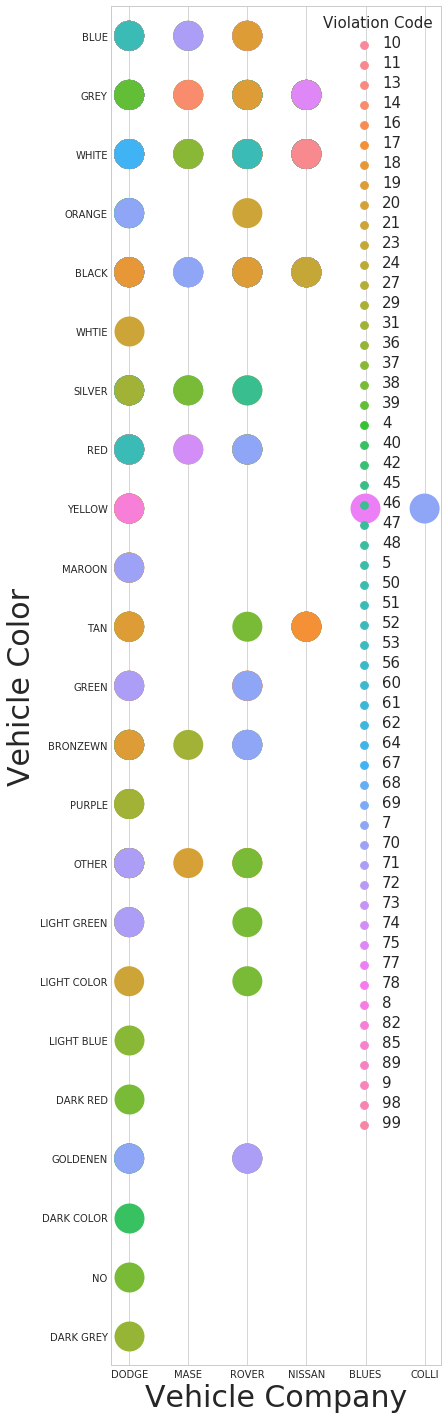

In [41]:
fig, ax = plt.subplots(figsize=(30, 25), subplot_kw=dict(aspect="equal"))
sns.set_style("white")
sns.set_palette("husl")
ax.set_ylabel('Vehicle Color\n',fontsize=30)
ax.set_xlabel('Vehicle Company\n',fontsize=30)

sns.stripplot(x="Vehicle Company", y="Vehicle Color", data=df.head (500), hue = 'Violation Code', size = 30, orient = 'h')
# ax.set_title('Correlation: Vehicle Color, Company and Violation Code', size = 30)
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title




In [9]:
with open('street_time_code_frequency.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    r = []
    for row in csvReader:
        r.append(row)

r1 = sorted (r, key = lambda x: x[3], reverse = True)
df1 = DataFrame (r1)
# df = df.transpose()
df1.columns = ['Street Name','Violation Time','Violation Code','freq']
# df.dropna(inplace = True)


df1.head()


,Street Name,Violation Time,Violation Code,freq
0,E 91st St,Morning,20,9
1,Broadway,Morning,19,9
2,Broadway,Morning,46,9
3,Pearl St,Noon,14,9
4,LINDEN BLVD (W/B) @,Morning,7,9


[None, None]

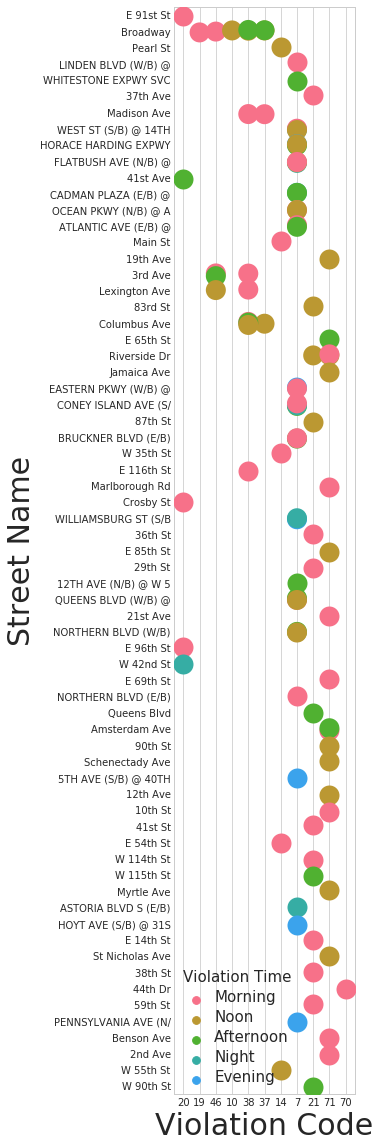

In [47]:
fig, ax = plt.subplots(figsize=(30, 20), subplot_kw=dict(aspect="equal"))
sns.set_style("whitegrid")
# sns.set_palette("husl")

ax.set_ylabel('Vehicle Color\n',fontsize=30)
ax.set_xlabel('Vehicle Company\n',fontsize=30)

ax = sns.stripplot(x="Violation Code", y="Street Name", hue="Violation Time",data=df1.head(100), size = 20,jitter=True)
# ax.set_title('Correlation among Vehicle Color, Violation Code and Daytime')
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='15') # for legend title
